# Script to run a Random Forest Model on our transformed data, Large Loans Only

Done with filtered transaction data

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns',100)

loans_base_df_m = pd.read_csv('./csv_files/loans_merged_all_transactions.csv')
loans_base_df = pd.read_csv('./csv_files/loans_merged_filtered_transactions.csv')

# Column Transformer

In [13]:

loans_base_df_m['percent_paid'] = 100*(loans_base_df_m['k_symbol_UVER_sum'] / loans_base_df_m['amount'])

loans_base_df_m.head()

ind_C_plus = (loans_base_df_m['status'] == 'C') & (loans_base_df_m['percent_paid']>=50)

ind_C_minus = (loans_base_df_m['status'] == 'C') & (loans_base_df_m['percent_paid']<50)

loans_base_df_m['status'][ind_C_plus] = 'C+'
loans_base_df_m['status'][ind_C_minus] = 'C-'

loans_base_df = loans_base_df[loans_base_df_m['amount']>100000]

loans_base_df.shape

/home/dan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/dan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


(377, 58)

In [14]:
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_var = [ #'amount_order','k_symbol_LEASING',
            #'k_symbol_Other', 'k_symbol_POJISTNE',
            #'k_symbol_SIPO', 'k_symbol_UVER',
            'amount_sum',
            'amount_mean', 'amount_std', 
            'balance_min', 'balance_max', 'balance_mean', 'balance_std',
            'type_PRIJEM_sum', 'type_VYBER_sum',
            'type_VYDAJ_sum', 'operation_Other_sum', 'operation_PREVOD NA UCET_sum',
            'operation_PREVOD Z UCTU_sum', 'operation_VKLAD_sum',
            'operation_VYBER_sum', 'operation_VYBER KARTOU_sum',
            #'k_symbol_DUCHOD_sum', 
            'k_symbol_Other_sum', 'k_symbol_POJISTNE_sum',
            'k_symbol_SANKC. UROK_sum', 'k_symbol_SIPO_sum', 'k_symbol_SLUZBY_sum',
            'k_symbol_UROK_sum', 
            #'k_symbol_UVER_sum', 
            'A4', 'A5', 'A6', 'A7', 'A8',
            'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16']

ord_var = ['gender','frequency','type_y']
date_var = ['date_x','date_y', 'date_min', 'date_max','birth_date']
drop_var = ['amount_x','duration','payments','loan_id','account_id','district_id','type_x','issued']
#pass_col = 

loans_base_df = loans_base_df.replace([np.inf, -np.inf], np.nan)

#Seperate into C+ (more than half) and C- (less than half)


target_raw = loans_base_df['status'].copy()
target_raw[(target_raw == 'A') | (target_raw == 'C+')] = 0
target_raw[(target_raw == 'B')  | (target_raw == 'D') | (target_raw == 'C-')] = 1
#Build a column transforrner

numeric_transformer = SimpleImputer(missing_values = np.nan, strategy='median')
  
binary_transformer = OneHotEncoder(handle_unknown='ignore')

ordinal_transformer = OneHotEncoder(categories  = [ ['M','F'],
                                                     ['POPLATEK PO OBRATU','POPLATEK TYDNE','POPLATEK MESICNE'],
                                                     ['No Card','junior','classic','gold']])

preprocessor = ColumnTransformer(transformers = [ ('numerical', numeric_transformer, num_var),
                                                  ('ordinal',ordinal_transformer, ord_var)],
                                                  #('date','passthrough', date_var)],
                                                   remainder = 'drop')

X = loans_base_df.drop(columns = 'status')
y = target_raw 


#Save X, Y

#loans_base_df.to_csv('loan_merged.csv')


X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2, random_state = 42)


In [15]:
#loans_base_df['status']
#loans_base_df.to_csv('loan_merged.csv')

In [16]:
X_train_transformed = preprocessor.fit_transform(X_train)

X_val_transformed = preprocessor.fit_transform(X_val)

y_val = y_val.astype(bool)


In [17]:

ord_var_list = ['M','F'] +  ['POPLATEK PO OBRATU','POPLATEK TYDNE','POPLATEK MESICNE'] + ['No Card','junior','classic','gold']

transformed_columns = num_var +  ord_var_list # + date_var

print(X_train_transformed.shape)
print(len(transformed_columns))

X_train_transform_df = pd.DataFrame(X_train_transformed, columns = transformed_columns)

X_train_transform_df.head()

(301, 44)
44


,amount_sum,amount_mean,amount_std,balance_min,balance_max,balance_mean,balance_std,type_PRIJEM_sum,type_VYBER_sum,type_VYDAJ_sum,operation_Other_sum,operation_PREVOD NA UCET_sum,operation_PREVOD Z UCTU_sum,operation_VKLAD_sum,operation_VYBER_sum,operation_VYBER KARTOU_sum,k_symbol_Other_sum,k_symbol_POJISTNE_sum,k_symbol_SANKC. UROK_sum,k_symbol_SIPO_sum,k_symbol_SLUZBY_sum,k_symbol_UROK_sum,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16,M,F,POPLATEK PO OBRATU,POPLATEK TYDNE,POPLATEK MESICNE,No Card,junior,classic,gold
0,1836818.0,12327.637584,14218.521183,1100.0,119288.0,49635.724832,23435.856688,945018.0,84076.0,807724.0,3748.0,157554.0,0.0,941270.0,734246.0,0.0,1675246.0,0.0,0.0,157554.0,270.0,3748.0,1204953.0,0.0,0.0,0.0,1.0,1.0,100.0,12541.0,0.2,0.43,167.0,85677.0,99107.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,933704.0,17617.056604,19736.694936,900.0,101929.0,48935.433962,24396.987985,483859.0,0.0,449845.0,1731.0,72170.0,481228.0,900.0,377675.0,0.0,898008.0,0.0,0.0,33890.0,75.0,1731.0,228848.0,15.0,40.0,18.0,2.0,6.0,57.2,9893.0,4.0,4.72,96.0,5623.0,5887.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,957827.0,11268.552941,13361.688528,300.0,140246.0,54575.447059,28027.556171,491261.0,67701.0,398865.0,2520.0,0.0,0.0,488741.0,466566.0,0.0,955142.0,0.0,0.0,0.0,165.0,2520.0,93931.0,74.0,21.0,10.0,1.0,8.0,56.9,8427.0,1.1,1.54,107.0,1874.0,1913.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,424713.0,3896.449541,4349.583600,500.0,46520.0,28250.064220,9371.457919,227468.0,0.0,197245.0,2144.0,0.0,0.0,225324.0,197245.0,0.0,422344.0,0.0,0.0,0.0,225.0,2144.0,95907.0,87.0,25.0,5.0,2.0,7.0,59.1,8388.0,2.4,2.94,87.0,1658.0,1668.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,1382243.0,11518.691667,12730.560947,600.0,84727.0,41285.208333,14317.109047,703254.0,133534.0,545455.0,3704.0,0.0,698950.0,600.0,678989.0,0.0,1378284.0,0.0,0.0,0.0,255.0,3704.0,117897.0,139.0,28.0,5.0,1.0,6.0,53.8,8814.0,4.7,5.74,107.0,2112.0,2059.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [18]:
X_train_transform_df.isna().sum()

amount_sum                      0
amount_mean                     0
amount_std                      0
balance_min                     0
balance_max                     0
balance_mean                    0
balance_std                     0
type_PRIJEM_sum                 0
type_VYBER_sum                  0
type_VYDAJ_sum                  0
operation_Other_sum             0
operation_PREVOD NA UCET_sum    0
operation_PREVOD Z UCTU_sum     0
operation_VKLAD_sum             0
operation_VYBER_sum             0
operation_VYBER KARTOU_sum      0
k_symbol_Other_sum              0
k_symbol_POJISTNE_sum           0
k_symbol_SANKC. UROK_sum        0
k_symbol_SIPO_sum               0
k_symbol_SLUZBY_sum             0
k_symbol_UROK_sum               0
A4                              0
A5                              0
A6                              0
A7                              0
A8                              0
A9                              0
A10                             0
A11           

In [19]:
from sklearn.ensemble import RandomForestClassifier
import eli5


rf_model = RandomForestClassifier(oob_score= True, random_state = 42)

rf_model.fit(X_train_transform_df, y_train.astype(bool))

eli5.show_weights(rf_model, feature_names = transformed_columns)

/home/dan/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/dan/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


Weight,Feature
0.0450 ± 0.0863,balance_max
0.0428 ± 0.0796,k_symbol_UROK_sum
0.0416 ± 0.0856,operation_VKLAD_sum
0.0405 ± 0.0780,amount_sum
0.0396 ± 0.0847,type_PRIJEM_sum
0.0385 ± 0.0822,type_VYDAJ_sum
0.0377 ± 0.0815,A5
0.0371 ± 0.0773,operation_VYBER_sum
0.0361 ± 0.0736,amount_mean
0.0355 ± 0.0673,amount_std


In [20]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

param_grid = {
     'ccp_alpha': [ 0.0, 0.01 ],
     'class_weight' : [ 'balanced'],
     'max_depth': [ 5, 10, 15, None],
     'max_features': ['auto'],
     'max_leaf_nodes': [ 10, 12, 14 , None],
     'min_impurity_decrease': [ 0.0, 0.001 ],
     'min_samples_leaf': [ 2, 4, 6],
     'min_samples_split': [ 2, 3, 4, 5 ],
     'min_weight_fraction_leaf': [ 0.0, 0.01 ],
     'n_estimators': [50, 65, 80, 95, 110, 150]
}

grid_search = RandomizedSearchCV(rf_model, param_grid, cv=5, verbose=1, random_state=42, n_iter=300, scoring='recall')
grid_search.fit(X_train_transform_df, y_train.astype(bool))

print(("best RF from grid search: %.3f"
       % grid_search.score(X_val_transformed, y_val)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed:  4.7min finished


best RF from grid search: 0.983


In [21]:
results  = pd.DataFrame(grid_search.cv_results_)

y_val.sum()

60

In [22]:
results.sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_weight_fraction_leaf,param_min_samples_split,param_min_samples_leaf,param_min_impurity_decrease,param_max_leaf_nodes,param_max_features,param_max_depth,param_class_weight,param_ccp_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.114212,0.007066,0.006896,0.000630,80,0,5,2,0.001,None,auto,None,balanced,0,"{'n_estimators': 80, 'min_weight_fraction_leaf...",0.980392,1.000000,1.000000,1.00,1.00,0.996078,0.007843,1
242,0.193162,0.010444,0.010878,0.000787,80,0,5,2,0,None,auto,15,balanced,0,"{'n_estimators': 80, 'min_weight_fraction_leaf...",0.980392,1.000000,1.000000,1.00,1.00,0.996078,0.007843,1
120,0.217672,0.014724,0.011920,0.000492,95,0.01,3,2,0.001,None,auto,15,balanced,0,"{'n_estimators': 95, 'min_weight_fraction_leaf...",0.980392,1.000000,1.000000,1.00,1.00,0.996078,0.007843,1
220,0.243373,0.002472,0.013073,0.000723,110,0,5,2,0.001,None,auto,10,balanced,0.01,"{'n_estimators': 110, 'min_weight_fraction_lea...",0.980392,0.980392,1.000000,1.00,1.00,0.992157,0.009606,4
19,0.154956,0.012217,0.008115,0.000916,95,0,5,2,0,None,auto,15,balanced,0.01,"{'n_estimators': 95, 'min_weight_fraction_leaf...",0.980392,0.980392,1.000000,1.00,1.00,0.992157,0.009606,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,0.210225,0.016695,0.011424,0.000358,95,0.01,4,6,0,None,auto,5,balanced,0.01,"{'n_estimators': 95, 'min_weight_fraction_leaf...",0.921569,0.960784,0.960784,0.90,0.88,0.924627,0.032318,296
119,0.141193,0.002888,0.008357,0.000095,65,0.01,5,6,0,10,auto,5,balanced,0.01,"{'n_estimators': 65, 'min_weight_fraction_leaf...",0.960784,0.901961,0.901961,0.92,0.92,0.920941,0.021493,297
49,0.093645,0.004560,0.005785,0.000403,65,0,3,6,0.001,10,auto,5,balanced,0.01,"{'n_estimators': 65, 'min_weight_fraction_leaf...",0.960784,0.901961,0.901961,0.92,0.92,0.920941,0.021493,297
278,0.124740,0.001109,0.007481,0.000046,65,0.01,4,6,0.001,None,auto,5,balanced,0.01,"{'n_estimators': 65, 'min_weight_fraction_leaf...",0.901961,0.921569,0.960784,0.90,0.90,0.916863,0.023418,299


In [23]:
y_pred_val = grid_search.predict(X_val_transformed)


from sklearn.metrics import confusion_matrix

x = confusion_matrix(y_val, y_pred_val)

tn = x[0,0]  
fp = x[0,1] 
fn = x[1,0] 
tp = x[1,1]

print([tp,fp])
print([fn,tn])



[59, 15]
[1, 1]


In [24]:
eli5.show_weights(grid_search.best_estimator_, feature_names = transformed_columns)

Weight,Feature
0.0517 ± 0.1159,balance_std
0.0479 ± 0.0927,amount_mean
0.0429 ± 0.0866,operation_Other_sum
0.0429 ± 0.0844,balance_mean
0.0399 ± 0.0890,amount_sum
0.0396 ± 0.0891,operation_VYBER_sum
0.0384 ± 0.0877,balance_max
0.0369 ± 0.0860,k_symbol_UROK_sum
0.0356 ± 0.0712,balance_min
0.0344 ± 0.0767,operation_VKLAD_sum


In [25]:
#Apply Model to other accounts, then see how they cluster...

grid_search.best_params_

{'n_estimators': 80,
 'min_weight_fraction_leaf': 0.0,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'min_impurity_decrease': 0.001,
 'max_leaf_nodes': None,
 'max_features': 'auto',
 'max_depth': None,
 'class_weight': 'balanced',
 'ccp_alpha': 0.0}

In [28]:
account_df = pd.read_csv("./csv_files/accounts_merged_all_transactions.csv")

account_transformed = preprocessor.fit_transform(account_df)

account_transform_df = pd.DataFrame(account_transformed, columns = transformed_columns)

In [29]:
account_transform_df['account_id'] = account_df['account_id']

In [30]:
account_transform_df.shape

(4500, 45)

In [31]:
loans_base_df.shape

(377, 58)

In [32]:
(~account_transform_df['account_id'].isin(loans_base_df['account_id'])).sum()

4123

In [33]:
account_df.isna().sum()

account_id                         0
district_id                        0
frequency                          0
date                               0
amount_order                     742
k_symbol_LEASING                 742
k_symbol_Other                   742
k_symbol_POJISTNE                742
k_symbol_SIPO                    742
k_symbol_UVER                    742
date_min                           0
date_max                           0
amount_sum                         0
amount_mean                        0
amount_std                         0
balance_min                        0
balance_max                        0
balance_mean                       0
balance_std                        0
type_PRIJEM_sum                    0
type_VYBER_sum                     0
type_VYDAJ_sum                     0
operation_Other_sum                0
operation_PREVOD NA UCET_sum       0
operation_PREVOD Z UCTU_sum        0
operation_VKLAD_sum                0
operation_VYBER_sum                0
o

In [34]:
account_no_loan_df = account_transform_df[(~account_transform_df['account_id'].isin(loans_base_df['account_id']))]

account_no_loan_df = account_no_loan_df.drop(columns='account_id')

account_no_loan_df.head()

,amount_sum,amount_mean,amount_std,balance_min,balance_max,balance_mean,balance_std,type_PRIJEM_sum,type_VYBER_sum,type_VYDAJ_sum,operation_Other_sum,operation_PREVOD NA UCET_sum,operation_PREVOD Z UCTU_sum,operation_VKLAD_sum,operation_VYBER_sum,operation_VYBER KARTOU_sum,k_symbol_Other_sum,k_symbol_POJISTNE_sum,k_symbol_SANKC. UROK_sum,k_symbol_SIPO_sum,k_symbol_SLUZBY_sum,k_symbol_UROK_sum,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16,M,F,POPLATEK PO OBRATU,POPLATEK TYDNE,POPLATEK MESICNE,No Card,junior,classic,gold
0,375192.0,1569.841004,1732.115246,1000.0,30415.0,15994.079498,3656.858500,194322.0,0.0,180870.0,3067.0,98080.0,165555.0,25700.0,82790.0,0.0,273445.0,0.0,0.0,98080.0,600.0,3067.0,70699.0,60.0,13.0,2.0,1.0,4.0,65.3,8968.0,2.8,3.35,131.0,1740.0,1910.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,3151514.0,6593.125523,7694.515237,1100.0,69302.0,36540.780335,11028.155962,1597055.0,217442.0,1337017.0,10719.0,553242.0,1537936.0,48400.0,1001217.0,0.0,2586578.0,0.0,0.0,472290.0,975.0,10719.0,1204953.0,0.0,0.0,0.0,1.0,1.0,100.0,12541.0,0.2,0.43,167.0,85677.0,99107.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,295030.0,2521.623932,2951.300633,1000.0,53447.0,26973.529915,10508.728242,173062.0,0.0,121968.0,2073.0,65013.0,0.0,170989.0,56955.0,0.0,232000.0,46007.0,0.0,14755.0,195.0,2073.0,95616.0,65.0,30.0,4.0,1.0,6.0,51.4,9307.0,3.8,4.43,118.0,2616.0,3040.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,350986.0,1887.021505,1956.829637,800.0,34870.0,21753.526882,5009.976472,192349.0,0.0,158637.0,2747.0,98812.0,188802.0,800.0,59825.0,0.0,98740.0,0.0,0.0,60262.0,435.0,2747.0,107870.0,84.0,29.0,6.0,1.0,6.0,58.0,8754.0,3.8,4.31,137.0,3804.0,3868.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,166891.0,1986.797619,1981.162764,600.0,32036.0,25090.023810,4752.452095,97489.0,0.0,69402.0,1566.0,37352.0,95323.0,600.0,32050.0,0.0,32440.0,0.0,0.0,37352.0,210.0,1566.0,58796.0,22.0,16.0,7.0,1.0,5.0,51.9,9045.0,3.1,3.60,124.0,1845.0,1879.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [35]:
y_acc_pred_val = grid_search.best_estimator_.predict(account_no_loan_df)


In [36]:
no_loans_df = account_no_loan_df[y_acc_pred_val==1]

preapp_loans_df = account_no_loan_df[y_acc_pred_val==0]

print(no_loans_df.shape)
print(preapp_loans_df.shape)


(4123, 44)
(0, 44)


In [37]:
X_zero = no_loans_df
X_one = preapp_loans_df

A = (X_one.describe().T - X_zero.describe().T)

print(A.sort_values(by ='mean', ascending=False))

                               count  mean  std  min  25%  50%  75%  max
amount_sum                   -4123.0   NaN  NaN  NaN  NaN  NaN  NaN  NaN
amount_mean                  -4123.0   NaN  NaN  NaN  NaN  NaN  NaN  NaN
amount_std                   -4123.0   NaN  NaN  NaN  NaN  NaN  NaN  NaN
balance_min                  -4123.0   NaN  NaN  NaN  NaN  NaN  NaN  NaN
balance_max                  -4123.0   NaN  NaN  NaN  NaN  NaN  NaN  NaN
balance_mean                 -4123.0   NaN  NaN  NaN  NaN  NaN  NaN  NaN
balance_std                  -4123.0   NaN  NaN  NaN  NaN  NaN  NaN  NaN
type_PRIJEM_sum              -4123.0   NaN  NaN  NaN  NaN  NaN  NaN  NaN
type_VYBER_sum               -4123.0   NaN  NaN  NaN  NaN  NaN  NaN  NaN
type_VYDAJ_sum               -4123.0   NaN  NaN  NaN  NaN  NaN  NaN  NaN
operation_Other_sum          -4123.0   NaN  NaN  NaN  NaN  NaN  NaN  NaN
operation_PREVOD NA UCET_sum -4123.0   NaN  NaN  NaN  NaN  NaN  NaN  NaN
operation_PREVOD Z UCTU_sum  -4123.0   NaN  NaN  Na

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


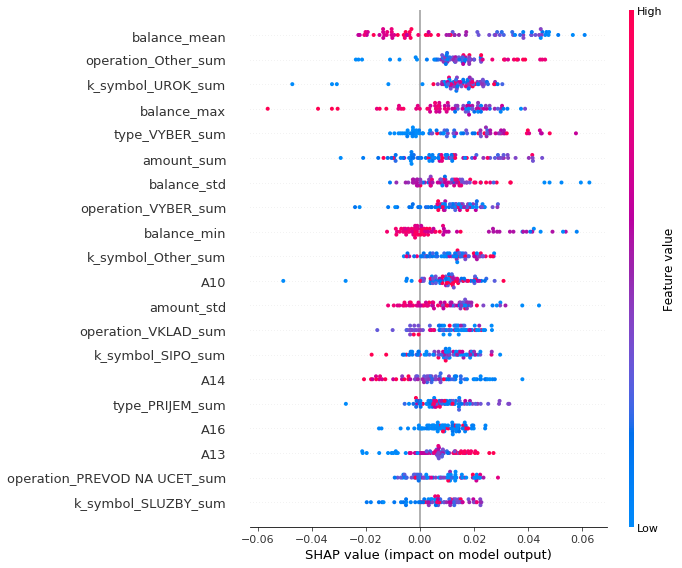

In [38]:
# Do Some SHAP value!?!?!?!

import shap

rf_explainer = shap.TreeExplainer(grid_search.best_estimator_)
rf_shap_values = rf_explainer.shap_values(X_val_transformed)

shap.initjs()
shap.force_plot(rf_explainer.expected_value[1],
                rf_shap_values[1],
                feature_names= transformed_columns)

shap.initjs()
shap.summary_plot(rf_shap_values[1],
                  features = X_val_transformed, 
                  feature_names = transformed_columns)